In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi, exp, log
from scipy.optimize import newton, bisect, minimize_scalar
from scipy.special import spherical_jn
import sys

np.set_printoptions(linewidth=132, suppress=True)

In [2]:
from pstudio import AE
ae = AE('C', xcname='LDA', relativity='SR', out='-')
ae.run()


scalar relativistic atomic calculation for C (Carbon, Z=6)
configuration: 1s2 2s2 2p2, 6 electrons
exchange-correlation: lda_x+lda_c_pz
2001 radial gridpoints in [1e-05,100]

Converged in 63 iterations

Energy contributions:
------------------------------------------------------------------------
Kinetic:      +37.269733 Ha     +1014.161102 eV 
Ionic:        -87.619337 Ha     -2384.243613 eV 
Hartree:      +17.627276 Ha      +479.662609 eV 
XC:            -4.732032 Ha      -128.765157 eV 
------------------------------------------------------------------------
Total:        -37.454308 Ha     -1019.183627 eV 

state      eigenvalue      eigenvalue        rmax
------------------------------------------------------------------------
1s2         -9.961701 Ha  -271.071678 eV    0.175
2s2         -0.501784 Ha   -13.654238 eV    1.218
2p2         -0.199279 Ha    -5.422666 eV    1.189



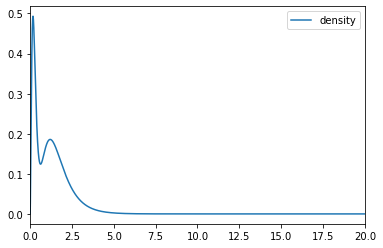

In [3]:
r = ae.rgd.r
# plot density
plt.figure()
plt.plot(r, ae.n*r*r, label='density')
plt.xlim(0,20)
plt.legend()
plt.show(block=False)

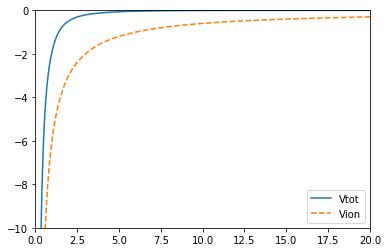

In [4]:
# plot the potential
plt.figure()
plt.plot(r, ae.vtot, label='Vtot')
plt.plot(r, ae.vion, label='Vion', linestyle='dashed')
plt.xlim(0,20)
plt.ylim(-10,0)
plt.legend()
plt.show(block=False)

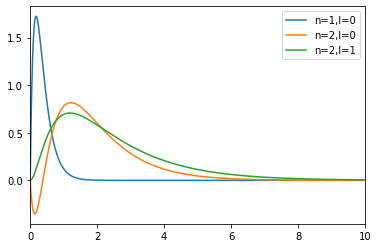

In [5]:
# plot orbitals
plt.figure()
for orb in ae.orbitals:
    plt.plot(r, orb.ur, label='n={0},l={1}'.format(orb.n,orb.l))
plt.xlim(0,10)
plt.legend()
plt.show()

rc (effective)= 1.4655478409559122 g= 1476
0.7813995847445941 0.7813995847308792


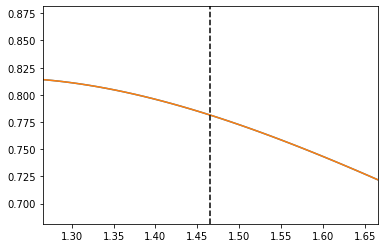

In [109]:
orb = ae.orbitals[1]
rc = orb.find_rmax(ae.rgd)*1.2
g = ae.rgd.floor(rc)
rc = r[g]
print('rc (effective)=', rc, 'g=', g)
l = orb.l
ae2s = orb.ur.copy()

# to calculate derivatives of AE wfc
p = np.polyfit(r[g-10:g+10], ae2s[g-10:g+10], deg=6)
print(ae2s[g], np.polyval(p,rc))

plt.plot(r, ae2s)
plt.plot(r, np.polyval(p, r))
plt.axvline(rc, color='black', linestyle='dashed')
plt.xlim(rc-0.2,rc+0.2)
plt.ylim(ae2s[g]-0.1, ae2s[g]+0.1)
plt.show()

dlogAE= -0.31319674590657165
dlogAE= -0.31319676890179543


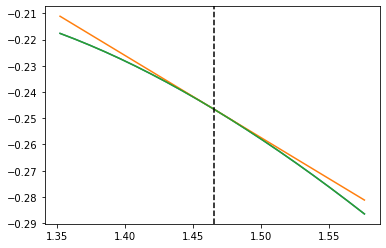

In [163]:
# calculate log der AE at rc
logAE = np.log(ae2s[g-10:g+10])
pp = np.polyfit(r[g-10:g+10], logAE, deg=6)
dlogAE = np.polyval(np.polyder(pp,1), rc)
print('dlogAE=', dlogAE)
dlogAE = np.polyval(np.polyder(p,1), rc) / np.polyval(p, rc)
print('dlogAE=', dlogAE)

plt.plot(r[g-10:g+10], logAE)
plt.plot(r[g-10:g+10], np.polyval(pp, rc) + dlogAE*(r[g-10:g+10]-rc))
plt.plot(r[g-10:g+10], np.polyval(pp, r[g-10:g+10]))

plt.axvline(rc, color='black', linestyle='dashed')
plt.show()



-0.3131967689044417
-0.3131967688972259
-0.3131967689132698
-0.31319676889279574
-0.31319676890058235


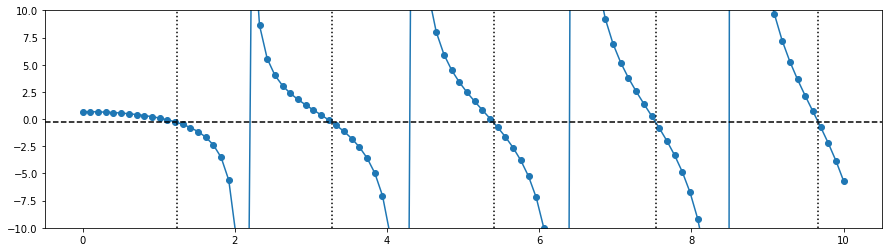

[1.24055563 3.28039509 5.39861682 7.53106636 9.66843216]


In [227]:
def dlog_bessel(l, q, r):
    return deriv1(lambda x: x*spherical_jn(l,q*x), r) / (r * spherical_jn(l,q*r))
    #return (spherical_jn(l,q*r) + q*r*spherical_jn(l,q*r,derivative=True)) / spherical_jn(l,q*r)

# find all possible q's
qrange = np.linspace(0, 10, 100)
qi = []
for i in range(len(qrange)-1):
    try:
        q0 = bisect(lambda q: dlog_bessel(l,q,rc)-dlogAE, a=qrange[i], b=qrange[i+1])
    except ValueError:
        pass
    else:
        if abs(dlog_bessel(l, q0, rc)) < 100:  # eliminate asymptotes
            print(dlog_bessel(l,q0,rc))
            qi.append(q0)

fig = plt.figure(figsize=(15,4))
plt.plot(qrange, dlog_bessel(l, qrange, rc), marker='o')
plt.axhline(dlogAE, color='black', linestyle='dashed')
for q_ in qi:
    plt.axvline(q_, color='black', linestyle='dotted')
plt.ylim(-10,10)
plt.show()
print(np.array(qi))

In [228]:
# first MT condition: norm conservation
ae_norm = np.sum(ae2s[:g]*ae2s[:g] * ae.rgd.dr[:g])
print('norm within rc:', ae_norm)

#derivatives of AE wfc
ae_deriv = [np.polyval(np.polyder(p,i),rc) for i in range(0,3)]
for i,d in enumerate(ae_deriv):
    print('{0}-th derivative: {1}'.format(i, d))
    
#fact = np.zeros(3)
#for i in range(3):
#    fact[i] = ae_deriv[0]/(rc*spherical_jn(l,rc*qi[i]))
#print()
#print('fact=', fact)

norm within rc: 0.49879075749060325
0-th derivative: 0.7813995847308792
1-th derivative: -0.24473182515891612
2-th derivative: -0.6545393945177249


In [234]:
def RRKJ3_function(r, l, c, qi):
    """Evaluate the RRKJ3 pseudowfc"""
    return r * (c[0]*spherical_jn(l, r*qi[0]) + \
                c[1]*spherical_jn(l, r*qi[1]) + \
                c[2]*spherical_jn(l, r*qi[2]))

def deriv1(f, x, dx=0.001):
    return (f(x+dx)-f(x-dx))/(2*dx)

def deriv2(f, x, dx=0.001):
    return (f(x+dx)-2*f(x)+f(x-dx))/(dx*dx)

def RRKJ3_linear_problem(c2, qi, rc, ae_deriv, l):
    """Construct the RRKJ3 linear problem as a function of c2"""
    # first the left hand side
    lhs = np.zeros((3,3))
    lhs[0,:] = np.array([rc*spherical_jn(l,qi[i]*rc) for i in range(3)])
    lhs[1,:] = np.array([deriv1(lambda x: x*spherical_jn(l,qi[i]*x), rc) for i in range(3)])
    lhs[2,:] = np.array([deriv2(lambda x: x*spherical_jn(l,qi[i]*x), rc) for i in range(3)])
    
    # then the left hand side
    rhs = ae_deriv[0:3]

    # eliminate the second equation (??)
    lhs = np.delete(lhs, (1), axis=0)
    rhs = np.delete(rhs, (1))
    
    # eliminate the column of c2 and move it to the rhs
    rhs -= c2*lhs[:,2]
    lhs = np.delete(lhs, (2), axis=1)
    return lhs, rhs

lhs, rhs = RRKJ3_linear_problem(1.0, qi, rc, ae_deriv, l)
print('LHS=')
np.savetxt(sys.stdout, lhs, fmt='%10g')
print('RHS=')
np.savetxt(sys.stdout, rhs, fmt='%10g')
print(np.linalg.solve(lhs,rhs))


LHS=
  0.781567  -0.303461
  -1.20281    3.26554
RHS=
  0.596478
     4.735
[1.5474868  2.01998367]


In [235]:
def RRKJ3_solve_linear_problem(c2, qi, rc, ae_deriv, l):
    # solve linear part of the system
    lhs, rhs = RRKJ3_linear_problem(c2, qi, rc, ae_deriv, l)
    c = np.linalg.solve(lhs, rhs)
    
    # put back c2 into the list
    c = list(c)
    c.append(c2)
    
    return c

def RRKJ3_calc_residual(c2, qi, rc, ae_norm, ae_deriv, rgd, l):
    # solve linear part of the system
    c = RRKJ3_solve_linear_problem(c2, qi, rc, ae_deriv, l)

    # fix norm-conserving relation
    g = rgd.floor(rc)
    r = rgd.r[:g]
    ps_norm = np.sum(RRKJ3_function(r, l, c, qi)**2 * rgd.dr[:g])
    diff = ps_norm - ae_norm
        
    return diff


def RRKJ3_find_coefficients(ae_norm, ae_deriv, rgd, rc, qi, l):
    c2 = 0   # starting guess

    res = RRKJ3_calc_residual(c2, qi, rc, ae_norm, ae_deriv, ae.rgd, l)
    print('initial c2=', c2, 'initial residual=', res)

    c2 = newton(lambda x: RRKJ3_calc_residual(x, qi, rc, ae_norm, ae_deriv, ae.rgd, l), c2)
    res = RRKJ3_calc_residual(c2, qi, rc, ae_norm, ae_deriv, ae.rgd, l)
    print('final c2=', c2, 'final residual=', res)
    
    c = RRKJ3_solve_linear_problem(c2, qi, rc, ae_deriv, l)
    print('RRKJ coefficients:', c)
    print('norm error     :', np.sum(RRKJ3_function(r[:g], l, c, qi)**2 * ae.rgd.dr[:g]) - ae_norm)

    return c

c = RRKJ3_find_coefficients(ae_norm, ae_deriv, ae.rgd, rc, qi, l)

initial c2= 0 initial residual= 0.12297614328056633
final c2= -0.2440734484910385 final residual= 5.551115123125783e-17
RRKJ coefficients: [0.9606970337039147, -0.2494050872019341, -0.2440734484910385]
norm error     : 5.551115123125783e-17


ae_norm= 0.49879075749060325
new norm= 0.4987907574906033
0th derivative: 0.7813995847308792 0.7813995847308791
1st derivative: -0.24473182515891612 -0.24473182515999392
2nd derivative: -0.6545393945177249 -0.6545393943513389


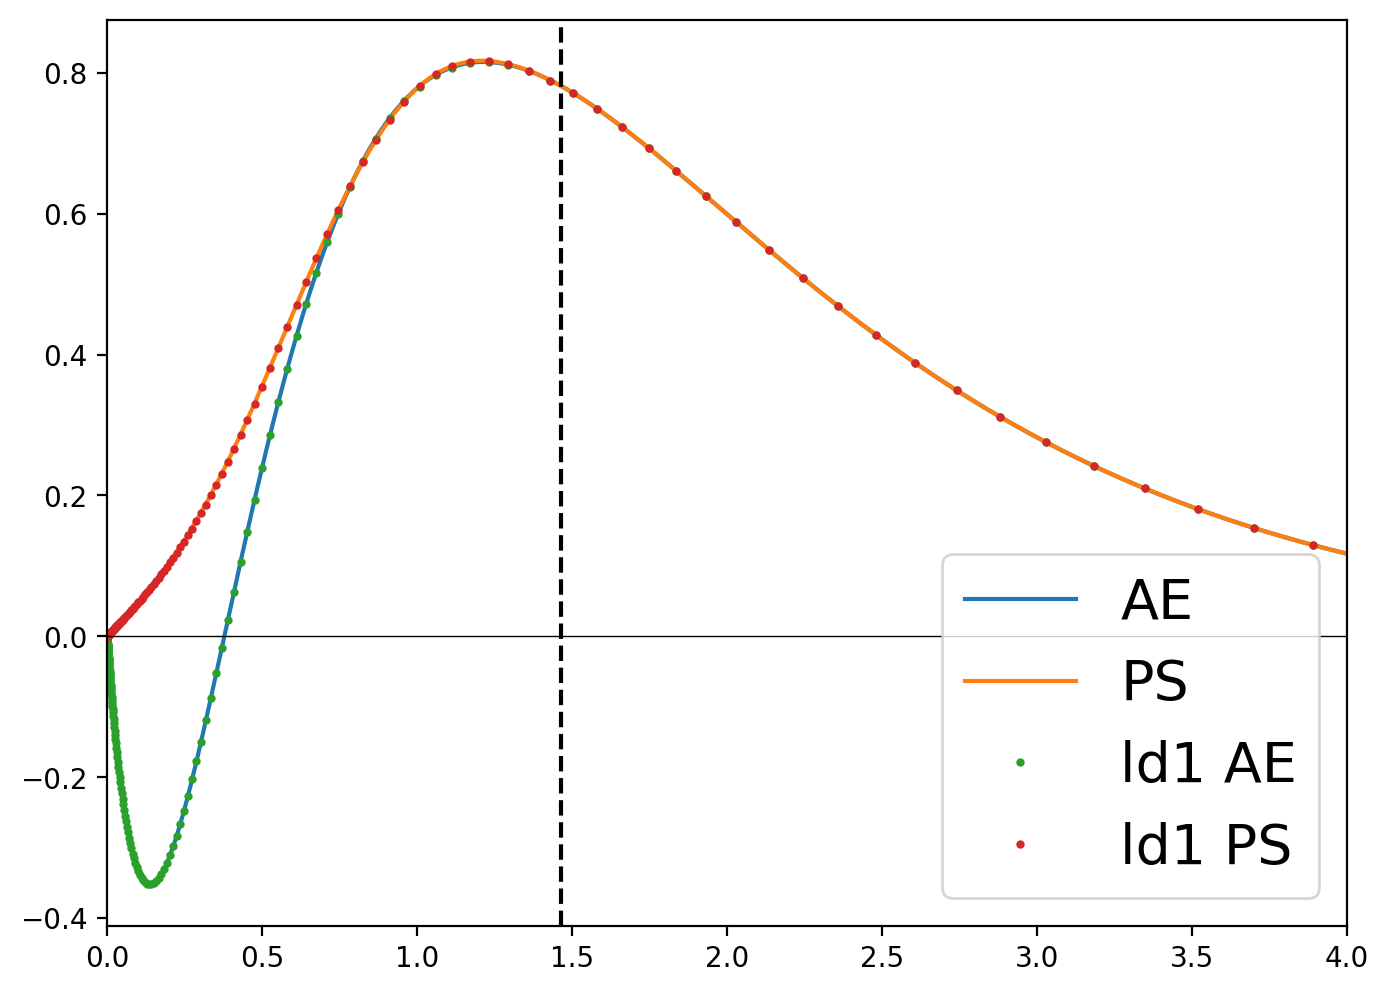

In [240]:
ps2s = ae2s.copy()
#qi = [1.24205460846424,        3.29198092967272, 5.41924991235136]               # ld1
#c = [0.960429475517407,       -0.254757413186097,       -0.244923041104708]      # after
print('ae_norm=', ae_norm)
print('new norm=', np.sum(RRKJ3_function(r[:g], l, c, qi)**2 * ae.rgd.dr[:g]))
ps2s[:g] = RRKJ3_function(r[:g], l, c, qi)
print('0th derivative:', ae_deriv[0], RRKJ3_function(rc, l, c, qi))
print('1st derivative:', ae_deriv[1], deriv1(lambda x: RRKJ3_function(x, l, c, qi), rc))
print('2nd derivative:', ae_deriv[2], deriv2(lambda x: RRKJ3_function(x, l, c, qi), rc))

ld1ae = np.loadtxt('TESTS/c.wfc')
ld1 = np.loadtxt('TESTS/cps.wfc')
#plt.xkcd(randomness=2)
fig = plt.figure(figsize=(8,6), dpi=200)
plt.plot(r, ae2s, label='AE')
plt.plot(r, ps2s, label='PS')
plt.plot(ld1ae[::10,0], -ld1ae[::10,2], linestyle='none', marker='o', markersize=2, label='ld1 AE')
plt.plot(ld1[::10,0], ld1[::10,1], linestyle='none', marker='o', markersize=2, label='ld1 PS')
plt.axvline(rc, color='black', linestyle='dashed')
plt.axhline(0, color='black', linewidth=0.5)
plt.xlim(0,4)
plt.legend(fontsize=20)
#plt.grid()
plt.savefig('pstudio.png', bbox_inches='tight')
plt.show()

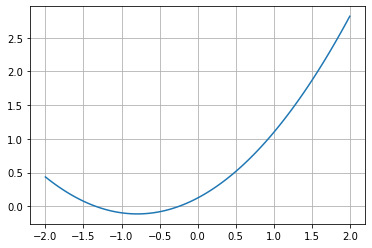

In [237]:
c0range = np.linspace(-2,2,100)
diff = np.zeros_like(c0range)
for i in range(len(c0range)):
    diff[i] = RRKJ3_calc_residual(c0range[i], qi, rc, ae_norm, ae_deriv, ae.rgd, l)
plt.plot(c0range, diff)
plt.grid()
plt.show()

In [80]:
del fact